In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import datetime, date, timedelta

import yfinance as yfin
from var import VaR
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
#from yahoofinancials import YahooFinancials

#pd.set_option('display.float_format', '{:.10f}'.format)

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Create a Github account if you do not already have one and download a VAR library.
Using the library that you have chosen and historical data (available from Yahoo Finance and other sources) calculate the VaR for your  investment portfolio.
Document your work in a presentation and post it to the Discussion Forum and comment on and discuss the document and posted work of others.

# Variables

In [3]:
start_date = datetime(2022, 1, 1)
end_date = datetime.now()
alpha = 0.05

yfin.pdr_override()

#start_date = "2022-01-01"
#end_date = "2023-08-31"
#alpha = 0.01

# Functions

# Load Data

In [4]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w5/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df

,Ticker,BondName,Class,Shares,Value
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,"106,383.0000","1,000.0000"
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,"14,201.0000",500.0000
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,"49,967.0000",750.0000
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000"
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,"108,467.0000","2,250.0000"
...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,"40,481.0000","3,000.0000"
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive,"40,221.0000","3,250.0000"
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive,"9,234.0000","2,000.0000"
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,"41,501.0000","3,000.0000"


In [5]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


## Calculate Percentage

In [6]:
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

In [7]:
ticker_lst = list(folio_df['Ticker'])
weights = (folio_df['port_percent'].values)

In [8]:
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)
price_df = price_df[['Adj Close']]
price_df.columns = price_df.columns.get_level_values(1)
price_df['C_A_S_H'] = 1

price_df

[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-03,10.4183,36.7510,13.1206,1,NaN,32.6081,35.1563,...,20.7575,23.9542,82.4521,107.5871,246.6520,77.9475,52.6388
2022-01-04,10.4087,36.6256,13.3690,1,NaN,32.6081,35.4690,...,20.7382,23.9542,82.2496,107.4563,246.4671,77.1101,52.6388
2022-01-05,10.3990,36.3122,13.4133,1,NaN,31.6710,34.6969,...,20.6996,23.8771,81.1115,104.3810,240.2957,74.6471,52.5716
2022-01-06,10.3796,36.2943,13.4932,1,NaN,31.6900,34.9129,...,20.6610,23.8097,80.5425,104.4745,240.9089,74.4895,52.5141
2022-01-07,10.3700,36.3480,13.5109,1,NaN,31.4912,34.6871,...,20.6225,23.7519,80.6389,103.7828,239.4682,73.6718,52.3894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,9.1100,34.1900,15.0000,1,19.4200,22.5900,32.1250,...,17.9100,20.3600,71.6500,75.1300,208.0600,70.2100,47.8100
2023-10-10,9.1400,34.3000,15.0100,1,19.4600,22.7000,32.3710,...,17.9300,20.3800,72.3900,75.4900,209.7000,70.5100,47.8600
2023-10-11,9.2100,34.4500,15.0600,1,19.8400,23.0900,32.3820,...,18.0000,20.4600,73.0200,76.8000,210.2800,71.0900,48.2100


In [9]:
percent_df = price_df.pct_change()
percent_df = percent_df[1:]
percent_df.fillna(0, inplace=True)
percent_df.index = pd.to_datetime(percent_df.index)

percent_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-04,-0.0009,-0.0034,0.0189,0.0000,0.0000,0.0000,0.0089,...,-0.0009,0.0000,-0.0025,-0.0012,-0.0007,-0.0107,0.0000
2022-01-05,-0.0009,-0.0086,0.0033,0.0000,0.0000,-0.0287,-0.0218,...,-0.0019,-0.0032,-0.0138,-0.0286,-0.0250,-0.0319,-0.0013
2022-01-06,-0.0019,-0.0005,0.0060,0.0000,0.0000,0.0006,0.0062,...,-0.0019,-0.0028,-0.0070,0.0009,0.0026,-0.0021,-0.0011
2022-01-07,-0.0009,0.0015,0.0013,0.0000,0.0000,-0.0063,-0.0065,...,-0.0019,-0.0024,0.0012,-0.0066,-0.0060,-0.0110,-0.0024
2022-01-10,-0.0028,0.0047,0.0007,0.0000,0.0000,-0.0066,-0.0028,...,-0.0009,-0.0016,-0.0087,-0.0058,-0.0033,-0.0008,-0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,0.0022,0.0038,0.0060,0.0000,0.0136,0.0121,0.0069,...,0.0073,0.0099,0.0025,0.0109,0.0079,0.0050,0.0061
2023-10-10,0.0033,0.0032,0.0007,0.0000,0.0021,0.0049,0.0077,...,0.0011,0.0010,0.0103,0.0048,0.0079,0.0043,0.0010
2023-10-11,0.0077,0.0044,0.0033,0.0000,0.0195,0.0172,0.0003,...,0.0039,0.0039,0.0087,0.0174,0.0028,0.0082,0.0073


In [10]:
price_df.query("index == '2023-09-11 00:00:00'")

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11 00:00:00,9.4000,35.2100,15.0100,1,20.7436,24.2468,33.1387,...,18.3700,20.8500,74.1083,80.8038,216.5903,72.2877,49.0532


In [11]:
price_df.corr()

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
ALTVX,1.0000,0.7081,-0.0096,NaN,0.6086,0.7261,0.5208,...,0.9610,0.9739,0.7261,0.7264,0.7074,0.4796,0.9362
BLUEX,0.7081,1.0000,0.2791,NaN,0.5192,0.6303,0.6818,...,0.7567,0.7419,0.8364,0.6316,0.8034,0.8561,0.7480
BPLSX,-0.0096,0.2791,1.0000,NaN,-0.2559,-0.2811,0.6371,...,-0.0458,-0.0453,0.5518,-0.2763,0.3706,0.4946,0.2787
C_A_S_H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DFAR,0.6086,0.5192,-0.2559,NaN,1.0000,0.9980,0.3228,...,0.7420,0.6988,0.2890,0.9989,0.6073,0.1583,0.2920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VIGI,0.7261,0.8364,0.5518,NaN,0.2890,0.4668,0.8077,...,0.7394,0.7358,1.0000,0.4677,0.8416,0.8160,0.8449
VNQ,0.7264,0.6316,-0.2763,NaN,0.9989,0.9997,0.4422,...,0.8035,0.7804,0.4677,1.0000,0.7153,0.3388,0.5185
VO,0.7074,0.8034,0.3706,NaN,0.6073,0.7114,0.9245,...,0.7458,0.7234,0.8416,0.7153,1.0000,0.7902,0.7289
VONG,0.4796,0.8561,0.4946,NaN,0.1583,0.3366,0.7881,...,0.5268,0.4976,0.8160,0.3388,0.7902,1.0000,0.6324


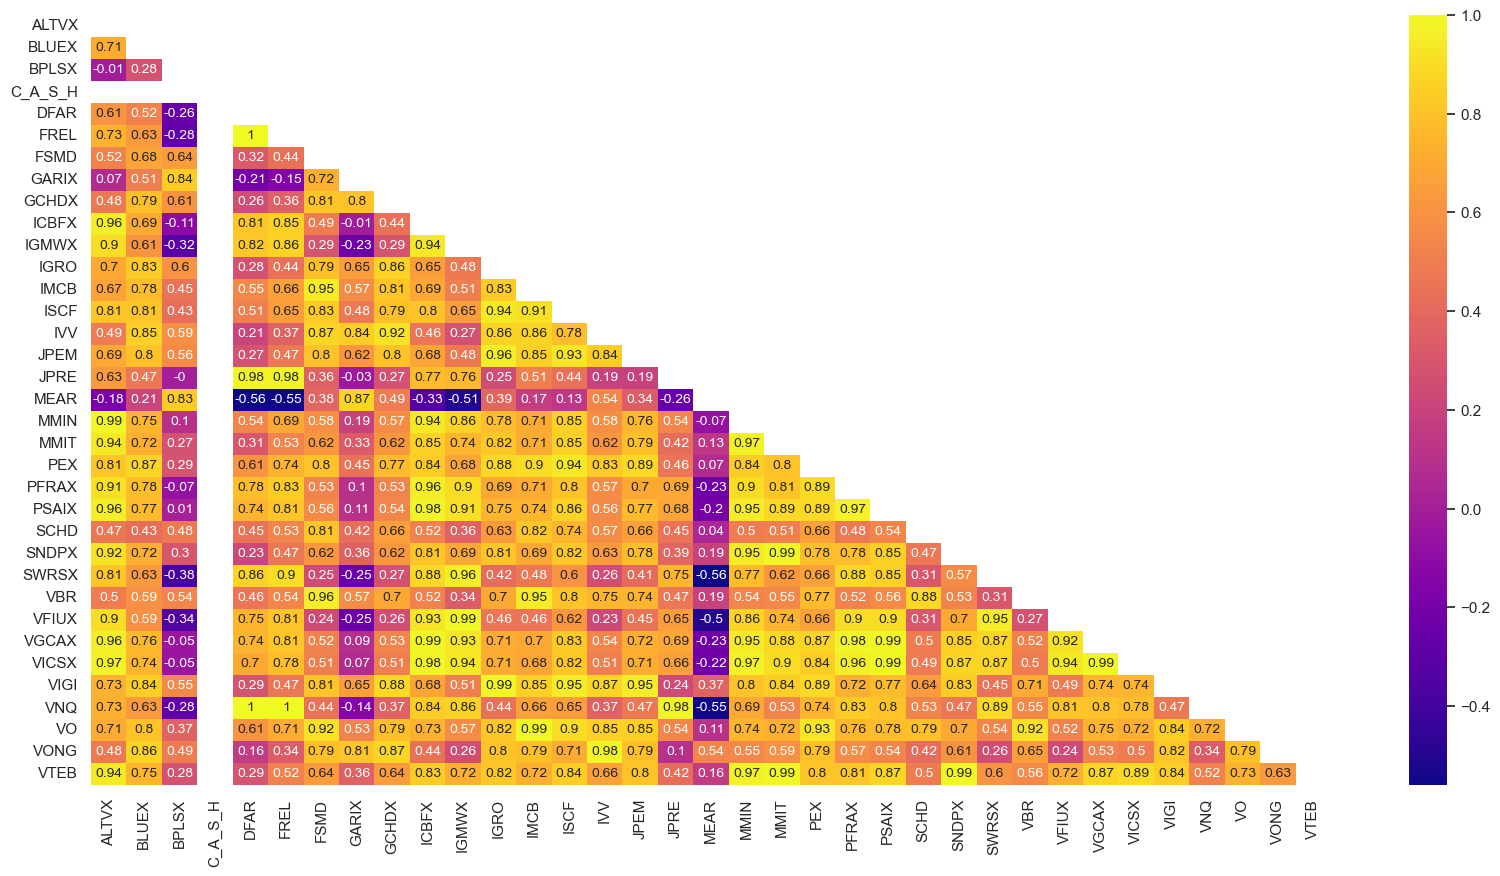

In [12]:
#t_df = df

plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# Calculate Portfolio Values

In [13]:
## Number of Shares

In [14]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df[['Shares']].round(0)

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,467.0000"
...,...
VIGI,"40,481.0000"
VNQ,"40,221.0000"
VO,"9,234.0000"


## Prices Timeseries

In [15]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-03,10.4183,36.7510,13.1206,1,NaN,32.6081,35.1563,...,20.7575,23.9542,82.4521,107.5871,246.6520,77.9475,52.6388
2022-01-04,10.4087,36.6256,13.3690,1,NaN,32.6081,35.4690,...,20.7382,23.9542,82.2496,107.4563,246.4671,77.1101,52.6388
2022-01-05,10.3990,36.3122,13.4133,1,NaN,31.6710,34.6969,...,20.6996,23.8771,81.1115,104.3810,240.2957,74.6471,52.5716
2022-01-06,10.3796,36.2943,13.4932,1,NaN,31.6900,34.9129,...,20.6610,23.8097,80.5425,104.4745,240.9089,74.4895,52.5141
2022-01-07,10.3700,36.3480,13.5109,1,NaN,31.4912,34.6871,...,20.6225,23.7519,80.6389,103.7828,239.4682,73.6718,52.3894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,9.1100,34.1900,15.0000,1,19.4200,22.5900,32.1250,...,17.9100,20.3600,71.6500,75.1300,208.0600,70.2100,47.8100
2023-10-10,9.1400,34.3000,15.0100,1,19.4600,22.7000,32.3710,...,17.9300,20.3800,72.3900,75.4900,209.7000,70.5100,47.8600
2023-10-11,9.2100,34.4500,15.0600,1,19.8400,23.0900,32.3820,...,18.0000,20.4600,73.0200,76.8000,210.2800,71.0900,48.2100


In [16]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df

,Date,Ticker,Price
0,2022-01-03,ALTVX,10.4183
1,2022-01-04,ALTVX,10.4087
2,2022-01-05,ALTVX,10.3990
3,2022-01-06,ALTVX,10.3796
4,2022-01-07,ALTVX,10.3700
...,...,...,...
15675,2023-10-09,VTEB,47.8100
15676,2023-10-10,VTEB,47.8600
15677,2023-10-11,VTEB,48.2100
15678,2023-10-12,VTEB,48.1000


## Add Asset Classes

In [17]:
l_df = folio_df[['Ticker','Class']] #.drop_duplicates() 
l_df

,Ticker,Class
0,ALTVX,Interest Rate Sensitive
1,BLUEX,Economically Sensitive
2,BPLSX,Economically Sensitive
3,C_A_S_H,Cash
4,DFAR,Economically Sensitive
...,...,...
30,VIGI,Economically Sensitive
31,VNQ,Economically Sensitive
32,VO,Economically Sensitive
33,VONG,Economically Sensitive


## Calculate Asset Value Overtime

In [18]:
merg_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merg_df['share_value'] = merg_df['Price'] * merg_df['Shares']
merg_df

,Date,Ticker,Price,Class,Shares,share_value
0,2022-01-03,ALTVX,10.4183,Interest Rate Sensitive,"106,383.0000","1,108,334.1340"
1,2022-01-04,ALTVX,10.4087,Interest Rate Sensitive,"106,383.0000","1,107,305.0786"
2,2022-01-05,ALTVX,10.3990,Interest Rate Sensitive,"106,383.0000","1,106,275.9218"
3,2022-01-06,ALTVX,10.3796,Interest Rate Sensitive,"106,383.0000","1,104,217.9125"
4,2022-01-07,ALTVX,10.3700,Interest Rate Sensitive,"106,383.0000","1,103,188.6542"
...,...,...,...,...,...,...
15675,2023-10-09,VTEB,47.8100,Interest Rate Sensitive,"20,333.0000","972,120.7579"
15676,2023-10-10,VTEB,47.8600,Interest Rate Sensitive,"20,333.0000","973,137.3924"
15677,2023-10-11,VTEB,48.2100,Interest Rate Sensitive,"20,333.0000","980,253.9114"
15678,2023-10-12,VTEB,48.1000,Interest Rate Sensitive,"20,333.0000","978,017.2690"


In [19]:
t_df = merg_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,share_value
0,2022-01-03,Cash,"4,469,000.0000"
1,2022-01-03,Economically Sensitive,"50,627,667.4001"
2,2022-01-03,Interest Rate Sensitive,"31,251,293.6787"
3,2022-01-04,Cash,"4,469,000.0000"
4,2022-01-04,Economically Sensitive,"50,744,738.4266"
...,...,...,...
1339,2023-10-12,Economically Sensitive,"48,140,189.2998"
1340,2023-10-12,Interest Rate Sensitive,"27,355,349.1715"
1341,2023-10-13,Cash,"4,469,000.0000"
1342,2023-10-13,Economically Sensitive,"47,898,857.8304"


In [20]:
t_df[t_df['Date'] == '2023-09-11']

,Date,Class,share_value
1269,2023-09-11,Cash,"4,469,000.0000"
1270,2023-09-11,Economically Sensitive,"50,055,536.4927"
1271,2023-09-11,Interest Rate Sensitive,"27,985,787.0448"


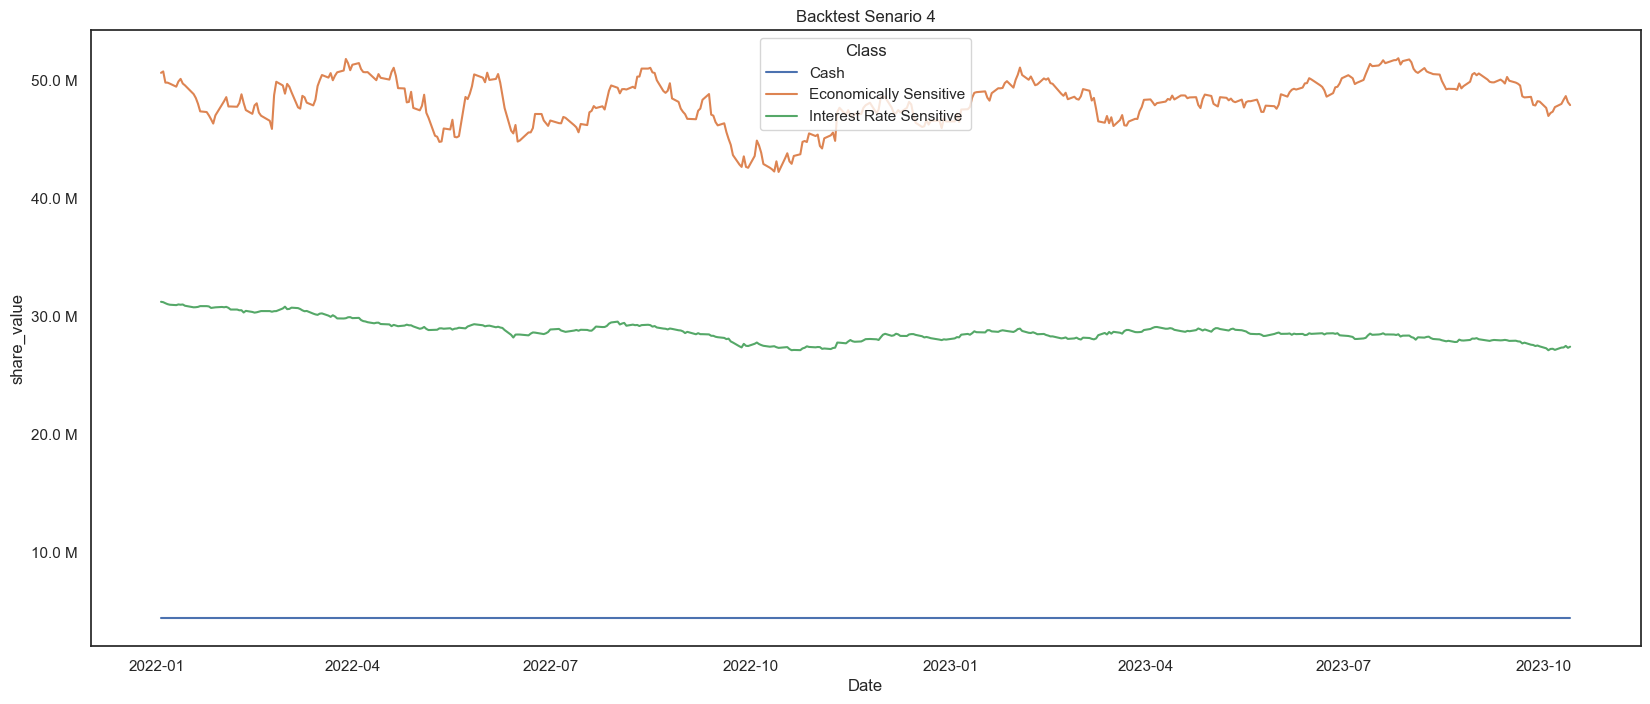

In [21]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Backtest Senario 4');

## Asset Class Correlation

In [22]:
s_df = t_df.copy()
s_df = s_df.pivot(index='Date', columns='Class', values='share_value')

s_df

Class,Cash,Economically Sensitive,Interest Rate Sensitive
Date,,,
2022-01-03,"4,469,000.0000","50,627,667.4001","31,251,293.6787"
2022-01-04,"4,469,000.0000","50,744,738.4266","31,217,884.8755"
2022-01-05,"4,469,000.0000","49,800,391.2632","31,129,343.0575"
2022-01-06,"4,469,000.0000","49,796,673.7816","31,051,416.8291"
2022-01-07,"4,469,000.0000","49,717,606.3787","31,003,337.2902"
...,...,...,...
2023-10-09,"4,469,000.0000","47,997,694.0395","27,375,147.5862"
2023-10-10,"4,469,000.0000","48,348,484.9985","27,385,679.9706"
2023-10-11,"4,469,000.0000","48,658,794.2354","27,516,594.2561"


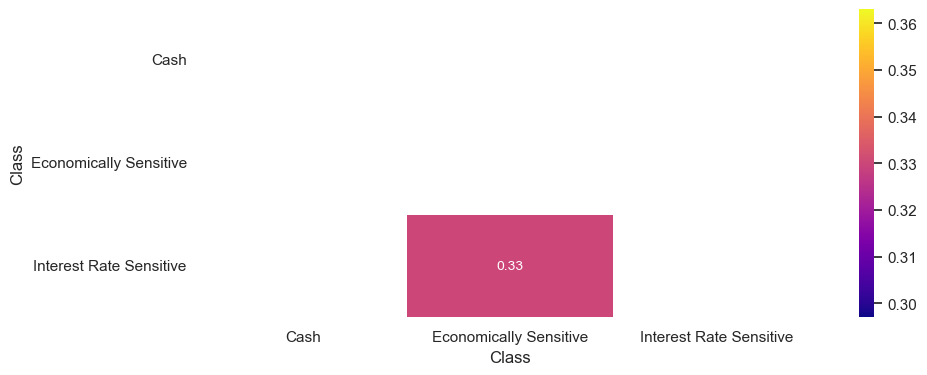

In [23]:
plt.figure(figsize=(10,4))
mask = np.zeros_like(s_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(s_df.corr().round(2), annot=True, mask=mask, cmap="plasma", annot_kws={"size": 10})

# Calculate VaR

In [24]:
percent_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-04,-0.0009,-0.0034,0.0189,0.0000,0.0000,0.0000,0.0089,...,-0.0009,0.0000,-0.0025,-0.0012,-0.0007,-0.0107,0.0000
2022-01-05,-0.0009,-0.0086,0.0033,0.0000,0.0000,-0.0287,-0.0218,...,-0.0019,-0.0032,-0.0138,-0.0286,-0.0250,-0.0319,-0.0013
2022-01-06,-0.0019,-0.0005,0.0060,0.0000,0.0000,0.0006,0.0062,...,-0.0019,-0.0028,-0.0070,0.0009,0.0026,-0.0021,-0.0011
2022-01-07,-0.0009,0.0015,0.0013,0.0000,0.0000,-0.0063,-0.0065,...,-0.0019,-0.0024,0.0012,-0.0066,-0.0060,-0.0110,-0.0024
2022-01-10,-0.0028,0.0047,0.0007,0.0000,0.0000,-0.0066,-0.0028,...,-0.0009,-0.0016,-0.0087,-0.0058,-0.0033,-0.0008,-0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,0.0022,0.0038,0.0060,0.0000,0.0136,0.0121,0.0069,...,0.0073,0.0099,0.0025,0.0109,0.0079,0.0050,0.0061
2023-10-10,0.0033,0.0032,0.0007,0.0000,0.0021,0.0049,0.0077,...,0.0011,0.0010,0.0103,0.0048,0.0079,0.0043,0.0010
2023-10-11,0.0077,0.0044,0.0033,0.0000,0.0195,0.0172,0.0003,...,0.0039,0.0039,0.0087,0.0174,0.0028,0.0082,0.0073


In [25]:
l2 = list(folio_df['Ticker'])
l1 = percent_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  35 l2:  35 dif:  set()


In [26]:
var = VaR(percent_df, weights, alpha=[0.05,0.025,0.01])
#var = VaR(percent_df, weights, alpha=0.05)
var

<VaR - μ: -0.03%, σ: 0.7129%, Portfolio σ: 0.7137%>

In [27]:
var.info

{'Daily Mean PnL': -0.0002546789650422607,
 'Daily Volatility': 0.007129406221716995,
 'Portfolio Volatility': 0.007137394354443087}

In [28]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0119,-0.0143,-0.0180,-0.0156,-0.0181,-0.0216,-0.1769,-0.1834,-0.1861


In [29]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.1925102407479589
Portfolio VaR(95.0) -998357.6484517837


In [30]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0237,-0.0251,-0.0268,-0.0289,-0.0289,-0.0289,-0.1769,-0.1834,-0.1861


In [31]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -2.3740465881536568
Portfolio VaR(95.0) -1987528.0631363601


In [32]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0119,-0.0142,-0.0169,-0.0150,-0.0170,-0.0194,-0.1769,-0.1834,-0.1861


In [33]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.195627907437431
Portfolio VaR(95.0) -1005936.6048663084


In [34]:
var.monte_carlo(stressed=True)

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0181,-0.0195,-0.0210,-0.0199,-0.0210,-0.0223,-0.5064,-0.5120,-0.5151


# Backtest

In [35]:
bth = var.backtest(method='h')

Backtest: Historic Method: 100%|██████████| 197/197 [00:00<00:00, 345.70it/s]


In [36]:
var.evaluate(bth)

,Amount,Percent,Mean Deviation,STD Deviation,Min Deviation,Max Deviation
Observations,197,1,0,0,0,0
VaR(95.0),2,0.0102,-0.0018,0.0007,-0.0010,-0.0025
VaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CVaR(95.0),1,0.0051,-0.0005,0.0000,-0.0005,-0.0005
CVaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CDaR(95.0),0,0.0000,0,0,0,0
CDaR(99.0),0,0.0000,0,0,0,0


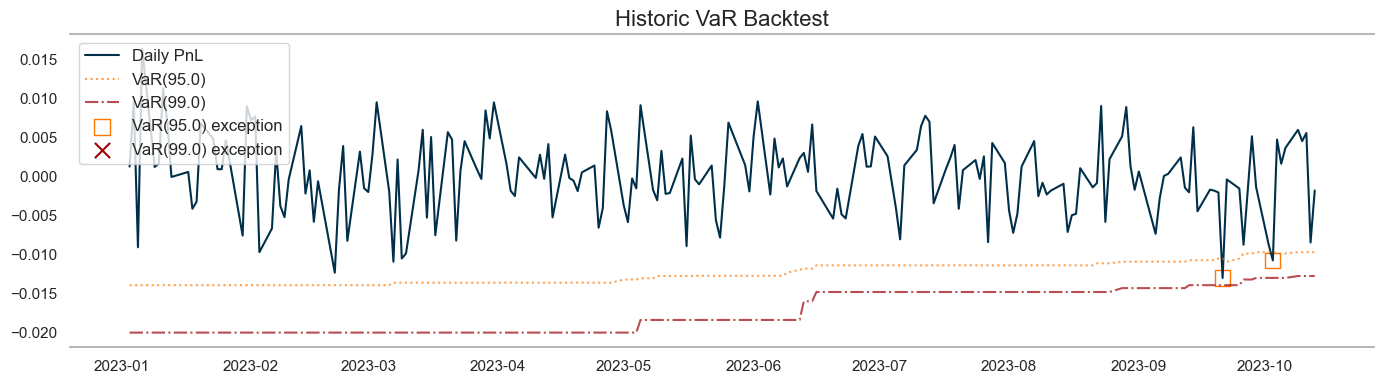

In [37]:
var.var_plot(bth)

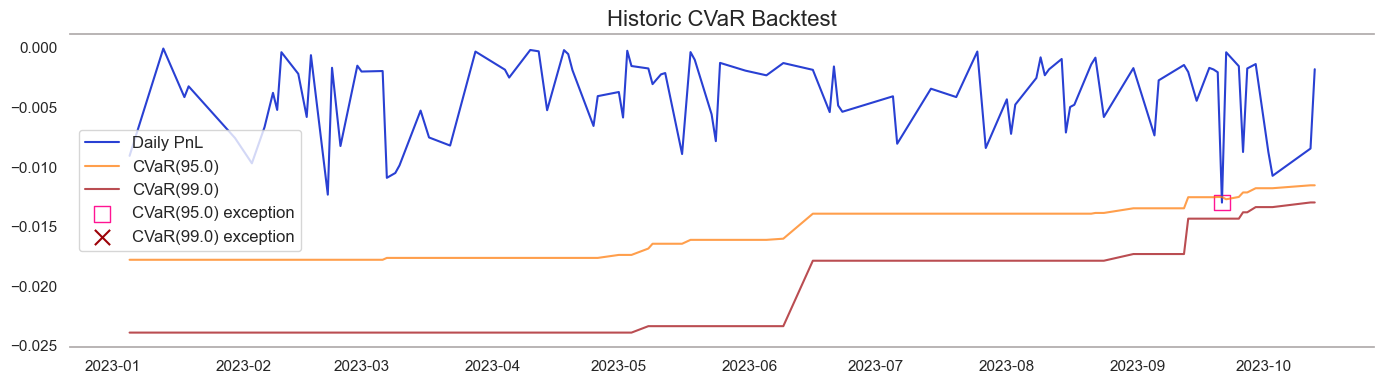

In [38]:
var.cvar_plot(bth)

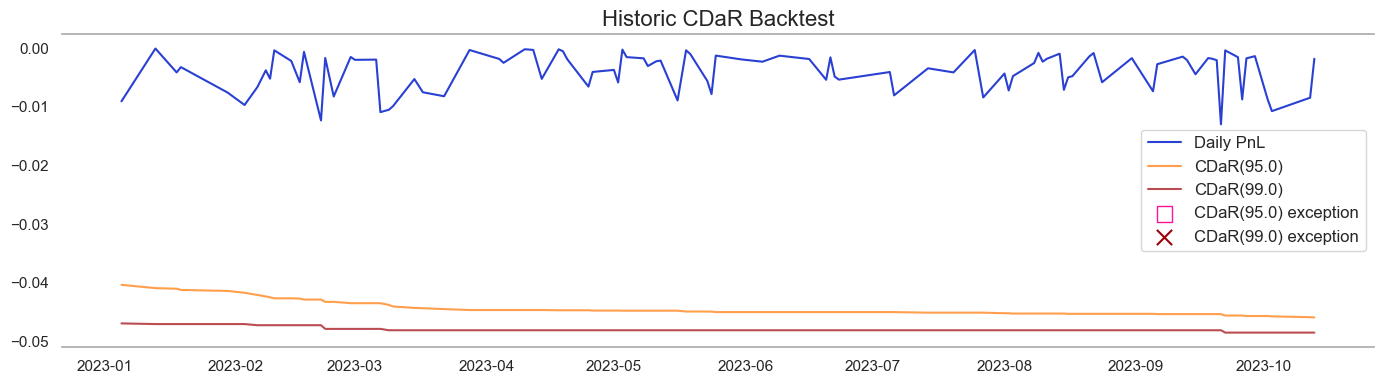

In [39]:
var.cdar_plot(bth)